<a href="https://colab.research.google.com/github/mprksa/kubus5/blob/main/KNN7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
import joblib
import imgaug.augmenters as iaa
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# Clone the repository
!git clone https://github.com/mprksa/Blocks2.git

Cloning into 'Blocks2'...
remote: Enumerating objects: 887, done.
remote: Counting objects: 100% (887/887), done.
remote: Compressing objects: 100% (873/873), done.
remote: Total 887 (delta 36), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (887/887), 1.82 GiB | 24.20 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (729/729), done.


In [42]:
# Fungsi untuk memuat gambar dan label dengan augmentasi data
def load_data(image_folder, label_file, image_size=(256, 256), augment=False):
    images = []
    labels = []

    with open(label_file, 'r') as f:
        data = json.load(f)

    image_id_to_filename = {image['id']: image['file_name'] for image in data['images']}
    category_id_to_name = {category['id']: category['name'] for category in data['categories']}

    augmenters = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flip
        iaa.Affine(rotate=(-25, 25)),  # rotate
        iaa.Multiply((0.8, 1.2))  # change brightness
    ])

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']

        img_path = os.path.join(image_folder, image_id_to_filename[image_id])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                images.append(img_hsv.flatten())
                labels.append(category_id_to_name[category_id])

                if augment:
                    aug_img = augmenters(image=img)
                    aug_img_hsv = cv2.cvtColor(aug_img, cv2.COLOR_BGR2HSV)
                    images.append(aug_img_hsv.flatten())
                    labels.append(category_id_to_name[category_id])

    return np.array(images), np.array(labels)

In [43]:
# Muat data dengan augmentasi
train_images, train_labels = load_data('Blocks2/train/images', 'Blocks2/train/labels.json', augment=True)
test_images, test_labels = load_data('Blocks2/test/images', 'Blocks2/test/labels.json')
val_images, val_labels = load_data('Blocks2/validation/images', 'Blocks2/validation/labels.json')

In [44]:
# Tampilkan jumlah gambar
print(f"Jumlah gambar untuk pelatihan: {len(train_images)}")
print(f"Jumlah gambar untuk testing: {len(test_images)}")
print(f"Jumlah gambar untuk validasi: {len(val_images)}")

Jumlah gambar untuk pelatihan: 1016
Jumlah gambar untuk testing: 72
Jumlah gambar untuk validasi: 144


In [59]:
# Tampilkan label sebelum konversi
print("Label sebelum konversi ke bentuk numerik:")
print("Training Labels:", np.unique(train_labels))
print("Testing Labels:", np.unique(test_labels))
print("Validation Labels:", np.unique(val_labels))

Label sebelum konversi ke bentuk numerik:
Training Labels: [0 1 2 3 4]
Testing Labels: [0 1 2 3 4]
Validation Labels: [0 1 2 3 4]


In [45]:
# Konversi label ke bentuk numerik
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

In [60]:
# Tampilkan label setelah konversi
print("\nLabel setelah konversi ke bentuk numerik:")
print("Training Labels:", np.unique(train_labels))
print("Testing Labels:", np.unique(test_labels))
print("Validation Labels:", np.unique(val_labels))


Label setelah konversi ke bentuk numerik:
Training Labels: [0 1 2 3 4]
Testing Labels: [0 1 2 3 4]
Validation Labels: [0 1 2 3 4]


In [46]:
# Normalisasi data
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)
val_images = scaler.transform(val_images)

In [47]:
# Penyetelan Hyperparameter dan Validasi Silang k-Fold
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(train_images, train_labels)
best_knn = grid_search.best_estimator_

In [48]:
# Decision Trees
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_images, train_labels)

DecisionTreeClassifier(random_state=42)

In [49]:
# Penggabungan: K-NN dan Decision Trees
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        return {'models': self.models}

ensemble_model = EnsembleModel([best_knn, dt])
ensemble_model.fit(train_images, train_labels)

In [50]:
# Evaluasi dengan validasi silang k-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_scores = cross_val_score(best_knn, train_images, train_labels, cv=kf)
dt_scores = cross_val_score(dt, train_images, train_labels, cv=kf)
ensemble_scores = cross_val_score(ensemble_model, train_images, train_labels, cv=kf)

In [51]:
print(f"K-NN Cross-Validation Scores: {knn_scores}")
print(f"Decision Trees Cross-Validation Scores: {dt_scores}")
print(f"Ensemble Model Cross-Validation Scores: {ensemble_scores}")

K-NN Cross-Validation Scores: [0.60294118 0.55172414 0.68472906 0.59605911 0.54679803]
Decision Trees Cross-Validation Scores: [0.98039216 0.99014778 0.98522167 0.98522167 0.97536946]
Ensemble Model Cross-Validation Scores: [0.75490196 0.74384236 0.79802956 0.74876847 0.73891626]


In [52]:
# Evaluasi model
train_predictions = ensemble_model.predict(train_images)
test_predictions = ensemble_model.predict(test_images)
val_predictions = ensemble_model.predict(val_images)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

print(f"Akurasi Pelatihan: {train_accuracy:.4f}")
print(f"Akurasi Testing: {test_accuracy:.4f}")
print(f"Akurasi Validasi: {val_accuracy:.4f}")

Akurasi Pelatihan: 0.8701
Akurasi Testing: 0.3333
Akurasi Validasi: 0.6458


In [53]:
# Analisis Kesalahan
val_class_report = classification_report(val_labels, val_predictions)
val_conf_matrix = confusion_matrix(val_labels, val_predictions)

In [54]:
print("Classification Report untuk Validasi:")
print(val_class_report)

Classification Report untuk Validasi:
              precision    recall  f1-score   support

           0       0.58      0.97      0.73        29
           1       0.61      0.69      0.65        29
           2       0.72      0.82      0.77        28
           3       0.60      0.31      0.41        29
           4       0.81      0.45      0.58        29

    accuracy                           0.65       144
   macro avg       0.66      0.65      0.63       144
weighted avg       0.66      0.65      0.62       144



In [55]:
print("Confusion Matrix untuk Validasi:")
print(val_conf_matrix)

Confusion Matrix untuk Validasi:
[[28  1  0  0  0]
 [ 3 20  0  3  3]
 [ 5  0 23  0  0]
 [ 5  7  8  9  0]
 [ 7  5  1  3 13]]


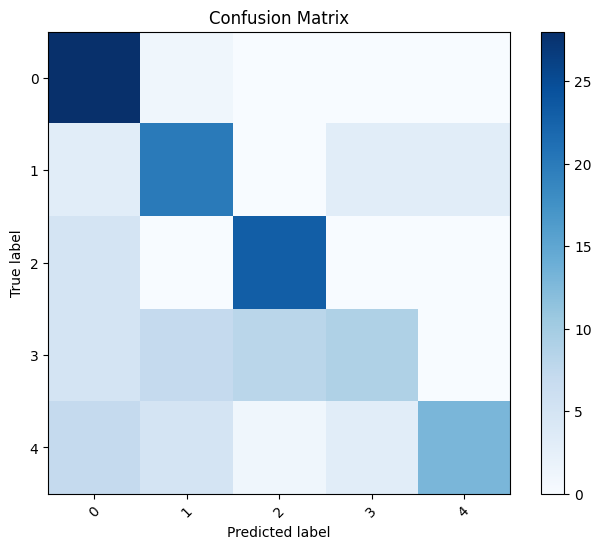

In [56]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(val_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(train_labels)))
plt.xticks(tick_marks, np.unique(train_labels), rotation=45)
plt.yticks(tick_marks, np.unique(train_labels))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [57]:
# Simpan model penggabungan
joblib.dump(ensemble_model, 'ensemble_model.pkl')

['ensemble_model.pkl']

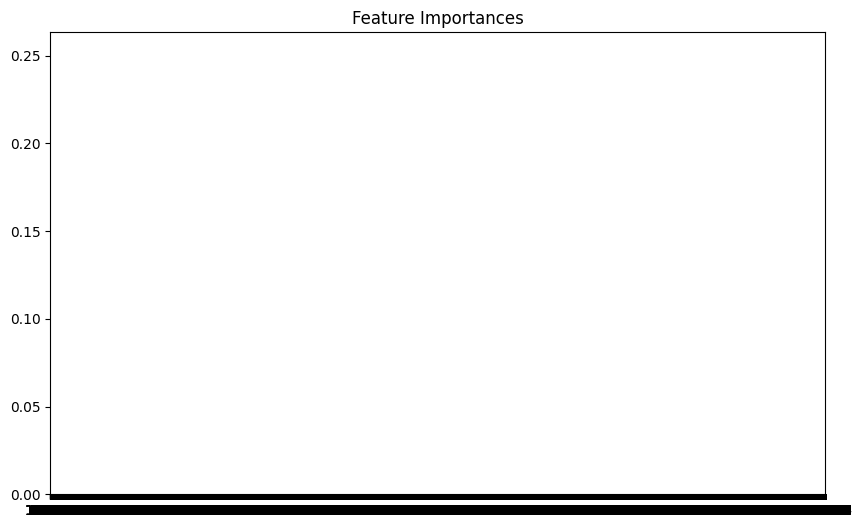

In [58]:
# Pentingnya Fitur pada Decision Trees
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(train_images.shape[1]), importances[indices], align="center")
plt.xticks(range(train_images.shape[1]), indices)
plt.xlim([-1, train_images.shape[1]])
plt.show()